In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler

C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Загрузим датасеты

In [2]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
PassengerId = data_test['PassengerId']

## Описание датасета

Задача: по 11 признакам, связанных с крушением Титаника (пол, возраст, родственники, кабина, порт отправления, стоимость билета, класс кабины) предсказать, выживет человек в катастрофе или нет. Датасеты разделены на обучающий и тестовый. Обучающий датасет включает в себя информацию по 891 пассажиру, тестовый датасет включает в себя информацию по 418 пассажирам.

In [3]:
print(data_train.shape)
print(data_test.shape)

(891, 12)
(418, 11)


## Предобработка данных

Посмотрим на данные

In [4]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


**Пропуски** в train:  
Age - 19%  
Cabin - 77%  
Embarked - 0.22%

In [6]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


**Пропуски** в test:  
Age - 20%    
Cabin - 78%  
Fare - 0.23%

### Feature engineering

Заполним пропуски в значениях и создадим следующие признаки:  
- Длина имени  
- Наличие кабины  
- Размер семьи  
- Один в семье
- Титул

In [7]:
data = pd.concat([data_train, data_test])

In [8]:
# Длина имени
data['Name_length'] = data['Name'].apply(len)

# Наличие кабины
data['Has_Cabin'] = data["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Размер семьи
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    
# Один в семье
data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1

In [9]:
# Функция "получить титул", которая получает титул из имени
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

# Создаем признак "титул"
data['Title'] = data['Name'].apply(get_title)

Посмотрим, какие титулы получились

In [10]:
data['Title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Ms            2
Major         2
Mlle          2
Don           1
Mme           1
Jonkheer      1
Dona          1
Countess      1
Capt          1
Lady          1
Sir           1
Name: Title, dtype: int64

Некоторые можно заменить эквивалентами:  
- Mlle на Miss  
- Ms на Miss  
- Mme на Mrs

In [11]:
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')

Заменим титулы, которые редко встречаются на титул "Rare"

In [12]:
data['Title'].value_counts()

Mr          757
Miss        264
Mrs         198
Master       61
Dr            8
Rev           8
Col           4
Major         2
Countess      1
Lady          1
Capt          1
Dona          1
Jonkheer      1
Don           1
Sir           1
Name: Title, dtype: int64

In [13]:
data['Title'] = data['Title'].replace(
    ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

Заполним пропуски в данных:  
- Age будем заполнять средним значением Age по выборке  
- Embarked будем заполнять самым часто встречающимся значением
- Fare будем заполнять медианой

In [14]:
data['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [15]:
data['Age'].fillna(data['Age'].mean(), inplace = True)
data['Embarked'].fillna('S', inplace = True)
data['Fare'].fillna(data['Fare'].median(), inplace = True)

Разделим "Age" и "Fare" на категории

In [16]:
data['CategoricalFare'] = pd.qcut(data['Fare'], 4)
data['CategoricalAge'] = pd.cut(data['Age'], 5)

Посмотрим, на какие категории разбились "Fare" и "Age"

In [17]:
cat_fare = data['CategoricalFare'].value_counts()
print(cat_fare)

(-0.001, 7.896]      337
(14.454, 31.275]     328
(31.275, 512.329]    323
(7.896, 14.454]      321
Name: CategoricalFare, dtype: int64


In [18]:
cat_age = data['CategoricalAge'].value_counts()
print(cat_age)

(16.136, 32.102]    787
(32.102, 48.068]    269
(0.0902, 16.136]    134
(48.068, 64.034]    106
(64.034, 80.0]       13
Name: CategoricalAge, dtype: int64


Преобразуем "Age" и "Fare" в вещественный тип в соответствии с категориями

In [19]:
data.loc[data['Fare'] <= 7.896, 'Fare'] = 0
data.loc[(data['Fare'] > 7.896) & (data['Fare'] <= 14.454), 'Fare'] = 1
data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31.275), 'Fare'] = 2
data.loc[ data['Fare'] > 31.275, 'Fare'] = 3
data['Fare'] = data['Fare'].astype(int)

In [20]:
data.loc[data['Age'] <= 16, 'Age'] = 0
data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
data.loc[ data['Age'] > 64, 'Age'] = 4;

In [21]:
data['Age'] = data['Age'].astype(int)

Преобразуем категориальные признаки в вещественные

In [22]:
data['Sex'] = data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
data['Title'] = data['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}).astype(int)
data['Title'] = data['Title'].fillna(int(0))
data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [23]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Name_length,Has_Cabin,FamilySize,IsAlone,Title,CategoricalFare,CategoricalAge
0,1,NaN,0,0,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,A/5 21171,23,0,2,0,1,"(-0.001, 7.896]","(16.136, 32.102]"
1,2,C85,1,3,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,PC 17599,51,1,2,0,3,"(31.275, 512.329]","(32.102, 48.068]"
2,1,NaN,0,1,"Heikkinen, Miss. Laina",0,3,3,0,0,1.0,STON/O2. 3101282,22,0,1,1,2,"(7.896, 14.454]","(16.136, 32.102]"
3,2,C123,0,3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1.0,113803,44,1,2,0,3,"(31.275, 512.329]","(32.102, 48.068]"
4,2,NaN,0,1,"Allen, Mr. William Henry",0,5,3,1,0,0.0,373450,24,0,1,1,1,"(7.896, 14.454]","(32.102, 48.068]"


In [24]:
data_train = data[:data_train.shape[0]]
data_test = data[data_train.shape[0]:]

In [25]:
data_train['Survived'] = data_train['Survived'].astype(int)

C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
data_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Name_length,Has_Cabin,FamilySize,IsAlone,Title,CategoricalFare,CategoricalAge
0,2,NaN,2,0,"Kelly, Mr. James",0,892,3,1,0,NaN,330911,16,0,1,1,1,"(-0.001, 7.896]","(32.102, 48.068]"
1,2,NaN,0,0,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,0,1,NaN,363272,32,0,2,0,3,"(-0.001, 7.896]","(32.102, 48.068]"
2,3,NaN,2,1,"Myles, Mr. Thomas Francis",0,894,2,1,0,NaN,240276,25,0,1,1,1,"(7.896, 14.454]","(48.068, 64.034]"
3,1,NaN,0,1,"Wirz, Mr. Albert",0,895,3,1,0,NaN,315154,16,0,1,1,1,"(7.896, 14.454]","(16.136, 32.102]"
4,1,NaN,0,1,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,0,1,NaN,3101298,44,0,3,0,3,"(7.896, 14.454]","(16.136, 32.102]"


### Feature selection

In [27]:
col_to_drop = ['PassengerId','Ticket', 'Cabin', 'SibSp','CategoricalAge', 'CategoricalFare', 'Name']
X_train = data_train.drop(col_to_drop, axis = 1)
X_test = data_test.drop(col_to_drop, axis = 1)

In [28]:
scaler_train = StandardScaler()
scaler_train.fit(X_train['Name_length'])


X_train['Name_length']=scaler_train.transform(X_train['Name_length'])
X_test['Name_length']=scaler_train.transform(X_test['Name_length'])

C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Alexander\Anaconda3\l

In [29]:
X_train.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,Survived,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,1,0,0,0,3,1,0,-0.427451,0,2,0,1
1,2,1,3,0,1,0,1,2.590962,1,2,0,3
2,1,0,1,0,3,0,1,-0.535252,0,1,1,2
3,2,0,3,0,1,0,1,1.836359,1,2,0,3
4,2,0,1,0,3,1,0,-0.319651,0,1,1,1


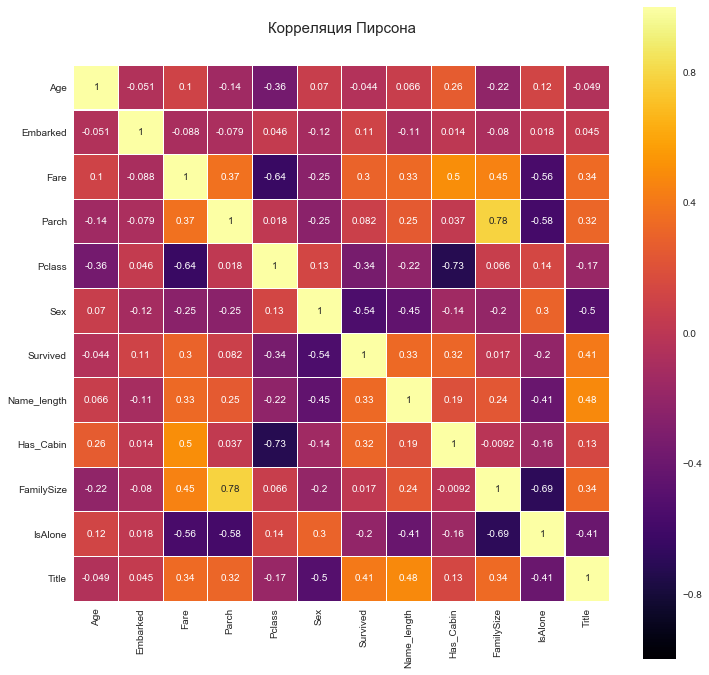

In [30]:
colormap = plt.cm.inferno
plt.figure(figsize=(12,12))
plt.title('Корреляция Пирсона', y=1.05, size=15)
sns.heatmap(X_train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, annot=True)

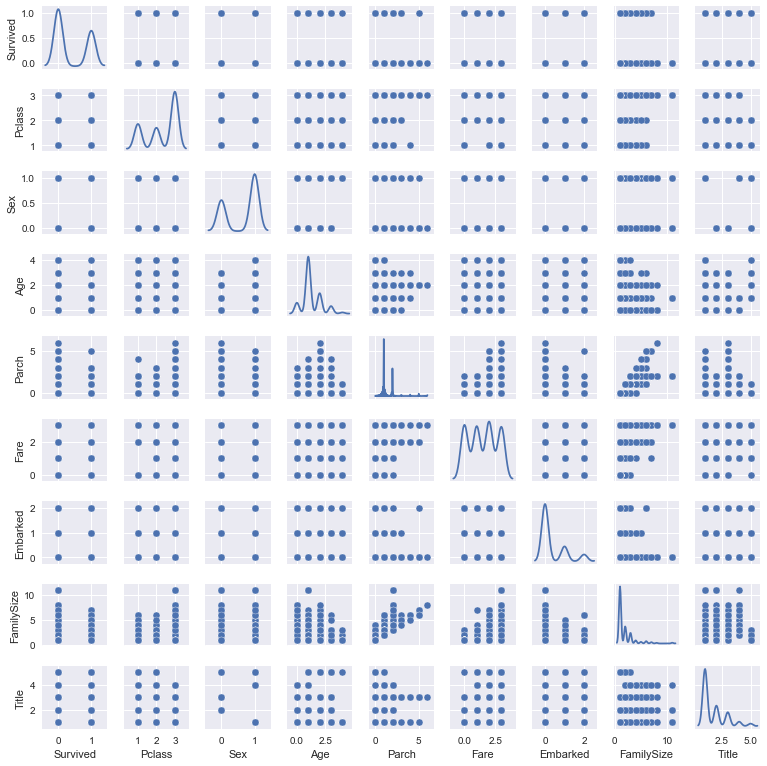

In [31]:
sns.pairplot(X_train[['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'FamilySize', 'Title']], size=1.2, diag_kind="kde")

In [32]:
y_train = X_train['Survived']
X_test = X_test.drop('Survived', axis = 1)

In [33]:
X_train = X_train.drop('Survived', axis = 1)

In [34]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((n_folds, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [35]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
random_state = 42
n_folds = 5
kf = KFold(ntrain, n_folds= n_folds, random_state = random_state)

In [36]:
rf = RandomForestClassifier(n_jobs = -1,warm_start=True,bootstrap=True,max_depth=6,min_samples_leaf=2,
                                  min_samples_split=4, max_features='sqrt',verbose=0, n_estimators = 500,
                                  random_state = random_state)

et = ExtraTreesClassifier(n_jobs=-1,max_depth=8,min_samples_leaf=2,verbose=0, n_estimators = 500,
                                random_state = random_state)

ab = AdaBoostClassifier(learning_rate= 0.75, n_estimators = 500, random_state = random_state)

gb = GradientBoostingClassifier(learning_rate=0.005, n_estimators=2300,
                                      max_depth=9,min_samples_leaf = 20,min_samples_split = 80, max_features = 10,
                                      subsample = 0.8, random_state = random_state)

svc = SVC(kernel='linear', C=0.025, random_state = random_state)

In [37]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values

In [38]:
rf_oof_train, rf_oof_test = get_oof(rf,X_train, y_train, X_test)
et_oof_train, et_oof_test = get_oof(et,X_train, y_train, X_test)
ab_oof_train, ab_oof_test = get_oof(ab,X_train, y_train, X_test)
gb_oof_train, gb_oof_test = get_oof(gb,X_train, y_train, X_test)
svc_oof_train, svc_oof_test = get_oof(svc,X_train, y_train, X_test)

C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:303: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


In [39]:
rf_features = rf.feature_importances_
et_features = et.feature_importances_
ab_features = ab.feature_importances_
gb_features = gb.feature_importances_

In [40]:
cols = data_train.drop(['PassengerId','Ticket', 'Cabin', 'SibSp','CategoricalAge', 'CategoricalFare', 'Name', 'Survived'], axis = 1).columns.values
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ab_features,
    'Gradient Boost feature importances': gb_features
    })
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1)

In [41]:
feature_dataframe

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.014,0.030099,0.078436,0.032623,Age,0.038789
1,0.008,0.031662,0.068684,0.024219,Embarked,0.033141
2,0.042,0.049388,0.102874,0.070118,Fare,0.066095
3,0.058,0.016132,0.022536,0.020206,Parch,0.029219
4,0.020,0.121663,0.092527,0.123656,Pclass,0.089462
5,0.002,0.385553,0.070454,0.201543,Sex,0.164887
6,0.712,0.058288,0.363454,0.106443,Name_length,0.310046
7,0.004,0.077504,0.029881,0.062291,Has_Cabin,0.043419
8,0.070,0.040782,0.059458,0.072375,FamilySize,0.060654
9,0.002,0.018163,0.014088,0.013087,IsAlone,0.011834


In [42]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ab_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ab_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [43]:
gbm = xgb.XGBClassifier(
 n_estimators= 10000, max_depth= 4, min_child_weight= 2, gamma=0.9,                        
 subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread= -1, scale_pos_weight=1).fit(x_train, y_train)

In [44]:
predictions = gbm.predict(x_test)

In [45]:
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)